# `CLOUD.jl` - 3D linear advection example

In [98]:
using CLOUD, OrdinaryDiffEq, Plots, Plots.PlotMeasures

## Define the physical problem

In [99]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(sin(θ)))) # end time for one period
CFL = 0.1

conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ),0.0))
initial_data = InitialDataCosine(A,k)
exact_solution = ExactSolution(conservation_law,initial_data);

## Set discretization parameters

In [100]:
M = 4
p = 4
p_map = 2
form = WeakConservationForm(mapping_form=StandardMapping(), 
    inviscid_numerical_flux=LaxFriedrichsNumericalFlux(1.0))
ode_algorithm = CarpenterKennedy2N54();

## Set up a `ModalTensor` scheme of degree `p` with `M` edges in each direction

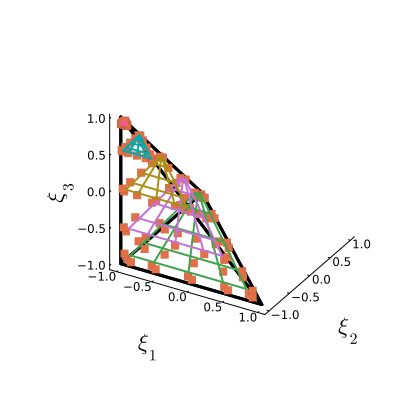

In [101]:
reference_approximation = ReferenceApproximation(
    ModalTensor(p), Tet(), mapping_degree=p_map)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L),(0.0,L)), (M,M,M),collapsed_orientation=true), 
    reference_approximation.reference_element, 0.1) 

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation, project_jacobian=false)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/advection_3d/", overwrite=true, clear=true)

plot(reference_approximation, volume_connect=true, fmt=:png)

## Run the solver, using a weight-adjusted approximation of the mass matrix inverse

In [102]:
ode_problem_1 = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    mass_matrix_solver=WeightAdjustedSolver())

h = L/(reference_approximation.N_p * spatial_discretization.N_e)^(1/3)
dt = CFL * h / a

CLOUD_reset_timer!()
sol = solve(ode_problem_1, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, 
    callback=save_callback(results_path, (0.0,T), floor(Int, T/(dt*50))))
CLOUD_print_timer()

 ────────────────────────────────────────────────────────────────────────────────
            Thread 1                    Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            31.6s /  97.9%           43.3GiB /  98.1%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 local residual          670k    27.8s   90.0%  41.6μs   38.1GiB   89.7%  59.7KiB
   apply operators       670k    23.3s   75.2%  34.8μs   30.3GiB   71.2%  47.4KiB
     volume terms        670k    8.79s   28.4%  13.1μs   14.5GiB   34.2%  22.8KiB
     mass matrix solve   670k    7.30s   23.6%  10.9μs   6.14GiB   14.4%  9.61KiB
     facet terms         670k    4.27s   13.8%  6.38μs   8.25GiB   19.4%  12.9KiB
     mul test function   670k    1.51s    4.9%  2.25μs   20.4MiB    0.0%    32.0B
   eval num flu

## Calculate the integral L<sup>2</sup> error norm

In [103]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data, T)...)
#without weight adjusted: 0.004798274556622129
#without projected Jacobian: 0.0048072745991968036

L2 error:
0.0048072745991968036


## Analyze conservation and energy dissipation

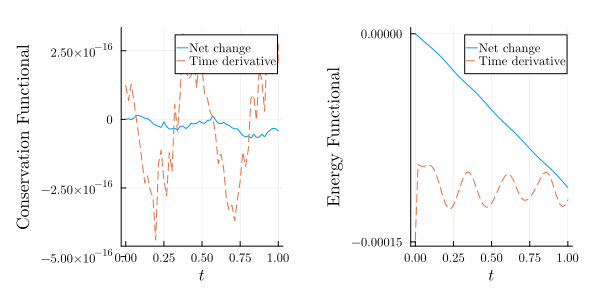

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tristanmontoya/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/tristanmontoya/.julia/packages/PlotUtils/igbcf/src/ticks.jl:191


In [104]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
        ylabel="Conservation Functional")
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)),
    ylabel="Energy Functional", yticks=[-1.5e-4,0.0])
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

## Postprocess for VTK visualization

In [105]:
for i in eachindex(sol.u)
    postprocess_vtk(spatial_discretization,
        string(results_path,"vis_", lpad(i,3,"0"), ".vtu"),
            sol.u[i],p_map=p_map,p_vis=p)
end